In [1]:
import numpy as np
import wandb
wandb.login(key=input())

wandb: Currently logged in as: gabi-kadlecova. Use `wandb login --relogin` to force relogin


True

In [3]:
project = 'test_zc'

api = wandb.Api(timeout=39)
runs = api.runs('gabi-kadlecova' + "/" + project)

In [6]:
run = next(iter(runs))
run.history()

,seed,mse_sample,_timestamp,tau_sample,corr_sample,r2_sample,test_time,fit_time,corr,r2,mse,_step,tau,_runtime,test_time_sample
0,42,0.586763,1.701953e+09,0.775184,0.925500,0.852606,0.048132,0.193916,0.931259,0.861578,0.590081,42,0.777724,1.388481,0.022514
1,42,0.543246,1.701953e+09,0.773750,0.929325,0.867949,0.042285,0.254255,0.936393,0.874366,0.533907,43,0.779721,1.987223,0.022911
2,42,0.629635,1.701953e+09,0.755334,0.918663,0.846766,0.116400,0.453659,0.915436,0.843653,0.664634,44,0.748573,3.021459,0.031381
3,42,0.501327,1.701953e+09,0.787773,0.936818,0.876325,0.108709,0.587809,0.938937,0.876208,0.526073,45,0.787374,4.161633,0.033979
4,42,0.568722,1.701953e+09,0.774788,0.930704,0.862893,0.107412,0.378829,0.934347,0.863793,0.580308,46,0.776569,5.108873,0.025004
5,42,0.622362,1.701953e+09,0.768162,0.924253,0.847386,0.035939,0.285094,0.927250,0.848420,0.650178,47,0.767352,5.605902,0.009609
6,42,0.673138,1.701953e+09,0.748544,0.910913,0.839323,0.029194,0.119146,0.920662,0.850726,0.631571,48,0.756404,5.865161,0.008359
7,42,0.661070,1.701953e+09,0.759113,0.919910,0.851128,0.029921,0.114560,0.922077,0.848870,0.645823,49,0.761183,6.126495,0.008488
8,42,0.633351,1.701953e+09,0.758259,0.921037,0.847028,0.028614,0.118671,0.918272,0.845703,0.656178,50,0.750365,6.390745,0.008656
9,42,0.561687,1.701953e+09,0.765854,0.923917,0.860278,0.031798,0.112141,0.927800,0.865977,0.569537,51,0.769620,6.642076,0.008009


In [19]:
res = []
for run in runs:
    # skip xgb for now
    if run.config['model'] != 'rf':
        continue
        
    if 'threshold' not in run.config['out_prefix']:
        continue
    
    #print(run.summary['corr_mean'])
    #print(run.config)
    res.append((run.config['train_size'], run.config['data_seed'], run.summary['corr_mean'], len({k: v for k, v in run.summary.items() if 'featimp' in k and 'mean' in k})))
    #print({k: v for k, v in run.summary.items() if 'featimp' in k})
    
    #if i > 10:
    #    break
    #i += 1
    #break

In [20]:
import pandas as pd

def create_entry(run, is_pca=False):
    # TODO uncertainty
    row = {}
    cfg_args = ['cfg', 'dataset', 'data_seed', 'proxy', 'train_size', 'use_all_proxies', 'use_features', 'use_onehot']
    for ca in cfg_args:
        if ca not in run.config:
            row[ca] = False
            continue
        
        row[ca] = run.config[ca]
    
    row['ch_s_pos'] = 'new' in run.config['out_prefix']
        
    if is_pca:
        prefix = run.config['out_prefix']
        prefix = prefix.replace('n_features-', 'nfeatures_')
        prefix = prefix.replace('theshold-', 'theshold_')

        prefix = prefix.split('-')
        for p in prefix:
            if not len(p):
                continue  
            p = p.split('_')
            if len(p) == 1:
                continue
            
            row[p[0]] = p[1]

    prox, cfg = row['proxy'], row['cfg']
    row['proxy'] = 'NONE' if prox is None or not len(prox) else prox
    row['cfg'] = 'NONE' if cfg is None or not len(cfg) else cfg
    row['corr'] = run.summary['corr_mean']
    row['tau'] = run.summary['tau_mean']
    return row

df = [create_entry(r, is_pca='pca' in project) for r in runs]
df = pd.DataFrame(df)
df

,cfg,dataset,data_seed,proxy,train_size,use_all_proxies,use_features,use_onehot,ch_s_pos,corr,tau
0,../zc_combine/configs/tnb101_macro_first.json,autoencoder,46,NONE,20,True,True,True,True,0.872916,0.683184
1,../zc_combine/configs/tnb101_macro_first.json,class_scene,46,NONE,1000,False,False,True,True,0.915130,0.748888
2,../zc_combine/configs/tnb101_macro_first.json,autoencoder,45,NONE,1000,False,False,True,True,0.886473,0.696160
3,../zc_combine/configs/tnb101_macro_first.json,autoencoder,45,NONE,1000,False,True,True,True,0.935222,0.771854
4,../zc_combine/configs/tnb101_macro_first.json,autoencoder,46,NONE,20,False,True,True,True,0.884960,0.697150
...,...,...,...,...,...,...,...,...,...,...,...
355,../zc_combine/configs/tnb101_macro_first.json,class_scene,42,NONE,100,False,True,True,False,0.900543,0.726682
356,../zc_combine/configs/tnb101_macro_first.json,class_scene,42,NONE,100,True,True,True,False,0.915801,0.748784
357,../zc_combine/configs/tnb101_macro_first.json,class_scene,42,NONE,20,False,True,True,False,0.853443,0.660204
358,../zc_combine/configs/tnb101_macro_first.json,autoencoder,42,NONE,20,False,True,True,False,0.760445,0.560845


In [28]:
def agg_func(row):
    version = "ch_s_pos - " if 'ch_s_pos' in row and row['ch_s_pos'] else ""
    
    if row['use_onehot']:
        if row['use_features']:
            return f"{version}Onehot + proxies + features" if row['use_all_proxies'] else f"{version}Onehot + features"
        else:
            return f"{version}Onehot + proxies" if row['use_all_proxies'] else f"{version}Onehot only"
    
    if row['use_all_proxies']:
        return f"{version}All proxies only" if not row['use_features'] else f"{version}Features + all proxies"
    if row['proxy'] is None or row['proxy'] == 'NONE':
        return f"{version}Features only"
    return f"Features + {row['proxy']}"

def agg_func_pca(row):
    val = f"threshold: {row['threshold']}" if not pd.isna(row['threshold']) else f"n_features: {row['nfeatures']}"
    prox = "+ all proxies" if row['use_all_proxies'] else 'only'
    
    return f"Features {prox}, {val}"

In [29]:
import numpy as np

plot_df = df.copy()
if 'pca' in project:
    plot_df['Dataset'] = plot_df[['use_all_proxies', 'threshold', 'nfeatures']].agg(agg_func_pca, axis=1)
else:
    plot_df['Dataset'] = plot_df[['ch_s_pos', 'proxy', 'use_all_proxies', 'use_features', 'use_onehot']].agg(agg_func, axis=1)

plot_df['Dataset']

0      ch_s_pos - Onehot + proxies + features
1                      ch_s_pos - Onehot only
2                      ch_s_pos - Onehot only
3                ch_s_pos - Onehot + features
4                ch_s_pos - Onehot + features
                        ...                  
355                         Onehot + features
356               Onehot + proxies + features
357                         Onehot + features
358                         Onehot + features
359               Onehot + proxies + features
Name: Dataset, Length: 360, dtype: object

In [30]:
plot_df.sort_values(by='Dataset', inplace=True)
plot_df

,cfg,dataset,data_seed,proxy,train_size,use_all_proxies,use_features,use_onehot,ch_s_pos,corr,tau,Dataset
269,../zc_combine/configs/tnb101_macro_first.json,class_scene,42,NONE,20,True,False,False,False,0.879435,0.691230,All proxies only
211,../zc_combine/configs/tnb101_macro_first.json,class_scene,45,NONE,100,True,False,False,False,0.905208,0.729474,All proxies only
214,../zc_combine/configs/tnb101_macro_first.json,class_scene,44,NONE,1000,True,False,False,False,0.935666,0.779064,All proxies only
215,../zc_combine/configs/tnb101_macro_first.json,autoencoder,45,NONE,20,True,False,False,False,0.791743,0.584693,All proxies only
216,../zc_combine/configs/tnb101_macro_first.json,class_scene,45,NONE,20,True,False,False,False,0.801033,0.607778,All proxies only
...,...,...,...,...,...,...,...,...,...,...,...,...
50,../zc_combine/configs/tnb101_macro_first.json,autoencoder,43,NONE,100,False,False,True,True,0.656626,0.465543,ch_s_pos - Onehot only
21,../zc_combine/configs/tnb101_macro_first.json,class_scene,46,NONE,100,False,False,True,True,0.872348,0.687822,ch_s_pos - Onehot only
20,../zc_combine/configs/tnb101_macro_first.json,class_scene,45,NONE,1000,False,False,True,True,0.919676,0.756011,ch_s_pos - Onehot only
78,../zc_combine/configs/tnb101_macro_first.json,autoencoder,42,NONE,20,False,False,True,True,0.518580,0.358149,ch_s_pos - Onehot only


In [31]:
xlims = {}
xlims

{}

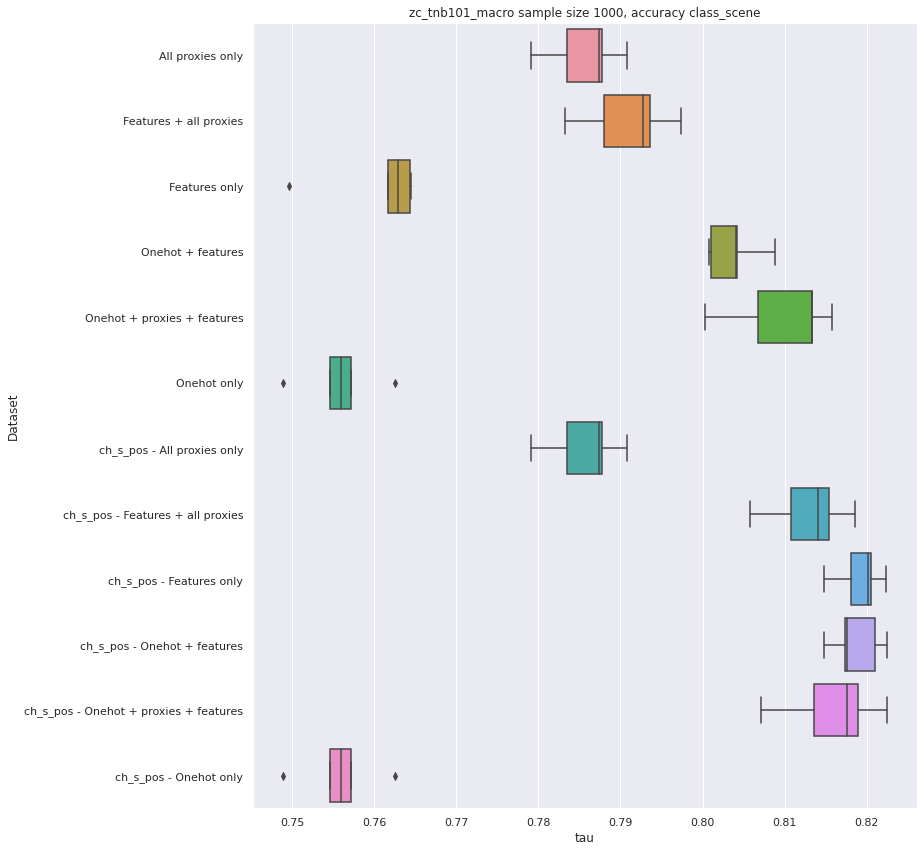

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

plot_dataset = 'class_scene' if 'macro' in project else run.config['dataset']
tsize = 1000
plot_condition = (plot_df['train_size'] == tsize) & ~(plot_df['cfg'].str.contains('full' if 'nb101' in project else 'first'))
if 'dataset' in plot_df:
    plot_condition &= plot_df['dataset'] == plot_dataset

plt.figure(figsize=(13, 12))
sns.boxplot(data=plot_df[plot_condition], y='Dataset', x='tau')
plt.title(f"{project} sample size {tsize}, accuracy {plot_dataset}")

if 'pca' not in project:
    xlims[(f"{project}_pca", tsize)] = plt.xlim()
else:
    down, up = xlims[(project, tsize)]
    plt.xlim(down, up)

plt.tight_layout()
#plt.savefig(f'../figs/{project}_boxes_{tsize}.png')
plt.show()

In [40]:
what_cfg = 'full'
group_cols = ['train_size', 'use_all_proxies', 'use_features', 'proxy']

small_df = df[(df['cfg'].str.contains('NONE')) | (df['cfg'].str.contains(what_cfg))].drop(columns='cfg')
small_df.groupby(group_cols).mean()

data_seed  use_onehot  \
train_size use_all_proxies use_features proxy                              
20         False           False        NONE       44.200000    1.000000   
                           True         NONE       44.100000    0.500000   
                                        epe_nas    44.000000    0.000000   
                                        fisher     44.000000    0.000000   
                                        grad_norm  44.000000    0.000000   
                                        grasp      44.000000    0.000000   
                                        jacov      44.000000    0.000000   
                                        l2_norm    44.000000    0.000000   
                                        nwot       44.000000    0.000000   
                                        plain      44.000000    0.000000   
                                        snip       44.000000    0.000000   
                                        synflow    44.000000    0.000000   
                                        zen        44.000000    0.000000   
           True            False        NONE       44.000000    0.000000   
                           True         NONE       43.818182    0.545455   
25         False           True         NONE       44.000000    0.000000   
                                        jacov      44.000000    0.000000   
           True            True         NONE       44.000000    0.000000   
100        False           False        NONE       43.500000    1.000000   
                           True         NONE       44.100000    0.500000   
                                        epe_nas    44.000000    0.000000   
                                        fisher     44.000000    0.000000   
                                        grad_norm  44.000000    0.000000   
                                        grasp      44.000000    0.000000   
                                        jacov      44.000000    0.000000   
                                        l2_norm    44.000000    0.000000   
                                        nwot       44.000000    0.000000   
                                        plain      44.000000    0.000000   
                                        snip       44.000000    0.000000   
                                        synflow    44.000000    0.000000   
                                        zen        44.000000    0.000000   
           True            False        NONE       44.000000    0.000000   
                           True         NONE       44.100000    0.500000   
276        False           True         NONE       44.000000    0.000000   
                                        jacov      44.000000    0.000000   
           True            True         NONE       44.000000    0.000000   
614        False           True         NONE       44.000000    0.000000   
                                        jacov      44.000000    0.000000   
           True            True         NONE       44.000000    0.000000   
1000       False           False        NONE       44.000000    1.000000   
                           True         NONE       44.000000    0.500000   
                                        epe_nas    44.000000    0.000000   
                                        fisher     44.000000    0.000000   
                                        grad_norm  44.000000    0.000000   
                                        grasp      44.000000    0.000000   
                                        jacov      44.000000    0.000000   
                                        l2_norm    44.000000    0.000000   
                                        nwot       44.000000    0.000000   
                                        plain      44.000000    0.000000   
                                        snip       44.000000    0.000000   
                                        synflow    44.000000    0.000000   
                       

In [210]:
#####################################################
from copy import deepcopy


def topology_str2structure(xstr):
    return TopologyStructure.str2structure(xstr)


class TopologyStructure:
    """A class to describe the topology, especially that used in NATS-Bench."""

    def __init__(self, genotype):
        assert isinstance(genotype, list) or isinstance(
            genotype, tuple
        ), "invalid class of genotype : {:}".format(type(genotype))
        self.node_num = len(genotype) + 1
        self.nodes = []
        self.node_N = []
        for idx, node_info in enumerate(genotype):
            assert isinstance(node_info, list) or isinstance(
                node_info, tuple
            ), "invalid class of node_info : {:}".format(type(node_info))
            assert len(node_info) >= 1, "invalid length : {:}".format(len(node_info))
            for node_in in node_info:
                assert isinstance(node_in, list) or isinstance(
                    node_in, tuple
                ), "invalid class of in-node : {:}".format(type(node_in))
                assert (
                    len(node_in) == 2 and node_in[1] <= idx
                ), "invalid in-node : {:}".format(node_in)
            self.node_N.append(len(node_info))
            self.nodes.append(tuple(deepcopy(node_info)))

    def tolist(self, remove_str):
        # convert this class to the list, if remove_str is 'none', then remove the 'none' operation.
        # note that we re-order the input node in this function
        # return the-genotype-list and success [if unsuccess, it is not a connectivity]
        genotypes = []
        for node_info in self.nodes:
            node_info = list(node_info)
            node_info = sorted(node_info, key=lambda x: (x[1], x[0]))
            node_info = tuple(filter(lambda x: x[0] != remove_str, node_info))
            if len(node_info) == 0:
                return None, False
            genotypes.append(node_info)
        return genotypes, True

    def node(self, index):
        assert index > 0 and index <= len(self), "invalid index={:} < {:}".format(
            index, len(self)
        )
        return self.nodes[index]

    def tostr(self):
        strings = []
        for node_info in self.nodes:
            string = "|".join([x[0] + "~{:}".format(x[1]) for x in node_info])
            string = "|{:}|".format(string)
            strings.append(string)
        return "+".join(strings)

    def check_valid(self):
        nodes = {0: True}
        for i, node_info in enumerate(self.nodes):
            sums = []
            for op, xin in node_info:
                if op == "none" or nodes[xin] is False:
                    x = False
                else:
                    x = True
                sums.append(x)
            nodes[i + 1] = sum(sums) > 0
        return nodes[len(self.nodes)]

    def to_unique_str(self, consider_zero=False):
        # this is used to identify the isomorphic cell, which rerquires the prior knowledge of operation
        # two operations are special, i.e., none and skip_connect
        nodes = {0: "0"}
        for i_node, node_info in enumerate(self.nodes):
            cur_node = []
            for op, xin in node_info:
                if consider_zero is None:
                    x = "(" + nodes[xin] + ")" + "@{:}".format(op)
                elif consider_zero:
                    if op == "none" or nodes[xin] == "#":
                        x = "#"  # zero
                    elif op == "skip_connect":
                        x = nodes[xin]
                    else:
                        x = "(" + nodes[xin] + ")" + "@{:}".format(op)
                else:
                    if op == "skip_connect":
                        x = nodes[xin]
                    else:
                        x = "(" + nodes[xin] + ")" + "@{:}".format(op)
                cur_node.append(x)
            nodes[i_node + 1] = "+".join(sorted(cur_node))
        return nodes[len(self.nodes)]

    def check_valid_op(self, op_names):
        for node_info in self.nodes:
            for inode_edge in node_info:
                # assert inode_edge[0] in op_names, 'invalid op-name : {:}'.format(inode_edge[0])
                if inode_edge[0] not in op_names:
                    return False
        return True

    def __repr__(self):
        return "{name}({node_num} nodes with {node_info})".format(
            name=self.__class__.__name__, node_info=self.tostr(), **self.__dict__
        )

    def __len__(self):
        return len(self.nodes) + 1

    def __getitem__(self, index):
        return self.nodes[index]

    @staticmethod
    def str2structure(xstr):
        if isinstance(xstr, TopologyStructure):
            return xstr
        assert isinstance(xstr, str), "must take string (not {:}) as input".format(
            type(xstr)
        )
        nodestrs = xstr.split("+")
        genotypes = []
        for i, node_str in enumerate(nodestrs):
            inputs = list(filter(lambda x: x != "", node_str.split("|")))
            for xinput in inputs:
                assert len(xinput.split("~")) == 2, "invalid input length : {:}".format(
                    xinput
                )
            inputs = (xi.split("~") for xi in inputs)
            input_infos = tuple((op, int(IDX)) for (op, IDX) in inputs)
            genotypes.append(input_infos)
        return TopologyStructure(genotypes)

    @staticmethod
    def str2fullstructure(xstr, default_name="none"):
        assert isinstance(xstr, str), "must take string (not {:}) as input".format(
            type(xstr)
        )
        nodestrs = xstr.split("+")
        genotypes = []
        for i, node_str in enumerate(nodestrs):
            inputs = list(filter(lambda x: x != "", node_str.split("|")))
            for xinput in inputs:
                assert len(xinput.split("~")) == 2, "invalid input length : {:}".format(
                    xinput
                )
            inputs = (xi.split("~") for xi in inputs)
            input_infos = list((op, int(IDX)) for (op, IDX) in inputs)
            all_in_nodes = list(x[1] for x in input_infos)
            for j in range(i):
                if j not in all_in_nodes:
                    input_infos.append((default_name, j))
            node_info = sorted(input_infos, key=lambda x: (x[1], x[0]))
            genotypes.append(tuple(node_info))
        return TopologyStructure(genotypes)

    @staticmethod
    def gen_all(search_space, num, return_ori):
        assert isinstance(search_space, list) or isinstance(
            search_space, tuple
        ), "invalid class of search-space : {:}".format(type(search_space))
        assert (
            num >= 2
        ), "There should be at least two nodes in a neural cell instead of {:}".format(
            num
        )
        all_archs = get_combination(search_space, 1)
        for i, arch in enumerate(all_archs):
            all_archs[i] = [tuple(arch)]

        for inode in range(2, num):
            cur_nodes = get_combination(search_space, inode)
            new_all_archs = []
            for previous_arch in all_archs:
                for cur_node in cur_nodes:
                    new_all_archs.append(previous_arch + [tuple(cur_node)])
            all_archs = new_all_archs
        if return_ori:
            return all_archs
        else:
            return [TopologyStructure(x) for x in all_archs]

In [62]:
struct = topology_str2structure('|nor_conv_3x3~0|+|none~0|none~1|+|skip_connect~0|nor_conv_3x3~1|none~2|')

In [64]:
struct.to_unique_str(consider_zero=True)

'#+((0)@nor_conv_3x3)@nor_conv_3x3+0'

In [67]:
struct = topology_str2structure('|nor_conv_3x3~0|+|none~0|none~1|+|skip_connect~0|nor_conv_3x3~1|nor_conv_3x3~2|')

In [68]:
struct.to_unique_str(consider_zero=True)

'(#+#)@nor_conv_3x3+((0)@nor_conv_3x3)@nor_conv_3x3+0'

In [66]:
# (3, 1, 0, 1, 3, 1)

In [69]:
struct.nodes

[(('nor_conv_3x3', 0),),
 (('none', 0), ('none', 1)),
 (('skip_connect', 0), ('nor_conv_3x3', 1), ('nor_conv_3x3', 2))]